In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def make_batch(N):
    x = torch.randint(0,9,size = (N,10))
    more_twos_than_fours = torch.FloatTensor([len(xx[xx==2]) > len(xx[xx==4]) for xx in x])
    return x,more_twos_than_fours.reshape(-1,1)

x,y = make_batch(100)
print(x.shape,y.shape)

torch.Size([100, 10]) torch.Size([100, 1])


In [2]:
numbers = torch.randint(0,9,size = (12,10))
embed = torch.nn.Embedding(10,5)
embedded = embed(numbers)
print(embedded.shape)

torch.Size([12, 10, 5])


In [3]:
key_proj = torch.nn.Linear(5,32)
val_proj = torch.nn.Linear(5,32)
print(key_proj(embedded).shape, val_proj(embedded).shape)

torch.Size([12, 10, 32]) torch.Size([12, 10, 32])


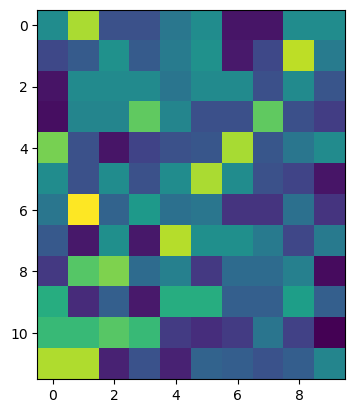

In [5]:
query = torch.randn(1,32)
keys = key_proj(embedded)
values = val_proj(embedded)
qk = torch.einsum('ik,bjk->bij',query,keys)
att = torch.softmax(qk/(32**0.5),dim=-1)

plt.imshow(att[:,0,:].detach())
plt.show()

In [6]:
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super(AttentionModel,self).__init__()
        self.embed_dim = 5
        self.att_dim = 5
        self.embed = torch.nn.Embedding(10,self.embed_dim)
        
        #one query
        self.query  = torch.nn.Parameter(torch.randn(1,self.att_dim))
        
        #used to compute keys
        self.WK = torch.nn.Linear(self.embed_dim,self.att_dim)
        
        #used to compute values
        self.WV = torch.nn.Linear(self.embed_dim,1)
        
        #final decision based on attention-weighted value
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(1,200),
            torch.nn.ReLU(),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )

    def attention(self,x):
        # compute attention
        queries = self.query
        keys = self.WK(x)
        qk = torch.einsum('ik,bjk->bij',queries,keys)
        att = torch.softmax(qk/(self.att_dim**0.5),dim=-1)
        return att
    
    def values(self,x):
        # compute values
        return self.WV(x)
                
    def forward(self,x):
        # compute final classification using attention, values and final NN
        x = self.embed(x)
        att = self.attention(x)
        values = self.values(x)
        aggreg = torch.einsum('bij,bjk->bik',att,values)
        return self.nn(aggreg[:,0,:])

In [7]:
def plot(model,N,traj):
    x,y = make_batch(N)
    f,axarr = plt.subplots(1,3)
    f.set_size_inches(13,2)
    ax = axarr[0]
    at = model.attention(model.embed(x))[:,0,:].detach().numpy()
    ax.imshow(at)
    ax = axarr[1]
    
    
    vals = model.values(model.embed(x))[:,:,0].detach().numpy()
    nan = np.ones_like(vals)*np.nan
    nan = np.where(at > 0.1, vals, nan)
    ax.imshow(nan,vmin = -1, vmax = 1)
    for i,xx in enumerate(x):
        for j,xxx in enumerate(xx):
            ax = axarr[0]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
            ax = axarr[1]
            ax.text(j,i,xxx.numpy(), c = 'r' if (xxx in [2,4]) else 'w')    
    ax = axarr[2]
    ax.plot(traj)

i=0, loss=0.677126944065094


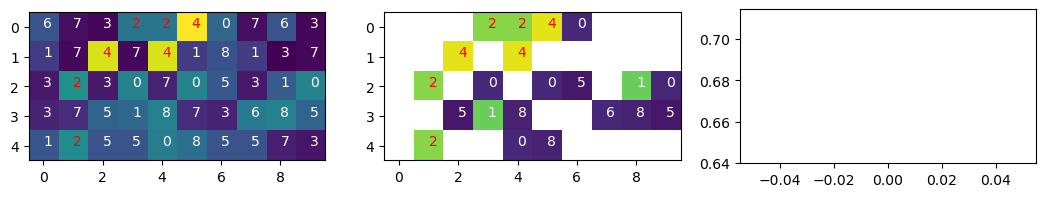

i=1000, loss=0.5469152927398682


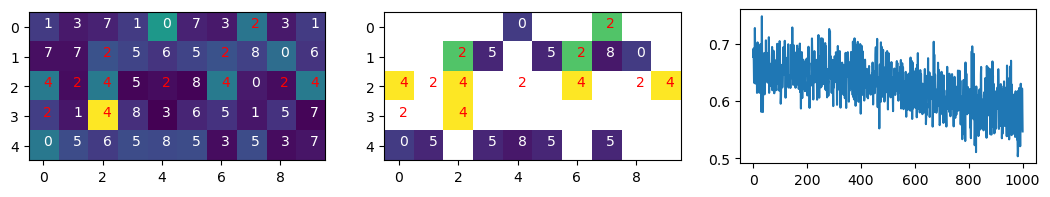

i=2000, loss=0.5282711386680603


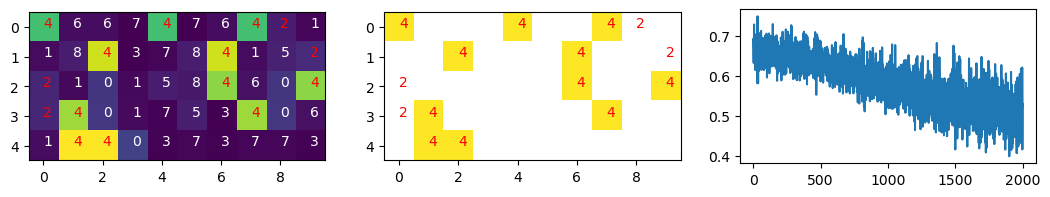

i=3000, loss=0.4831951856613159


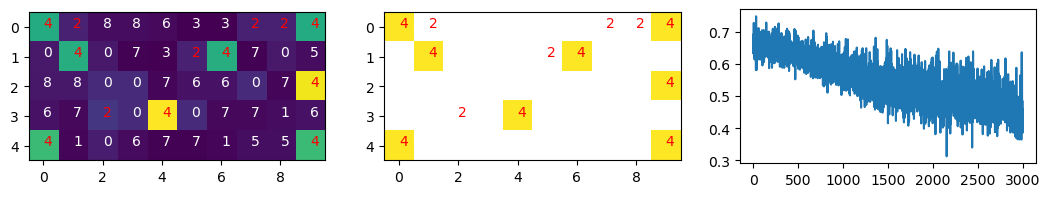

i=4000, loss=0.38681408762931824


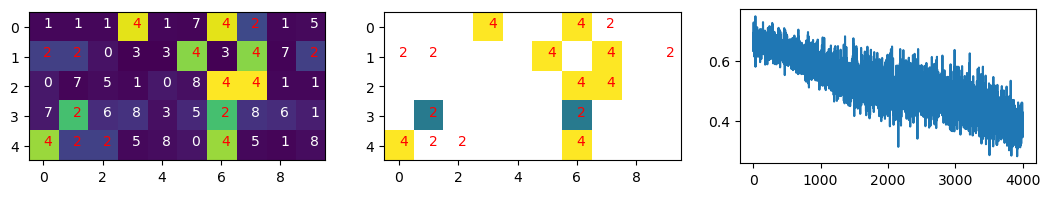

i=5000, loss=0.18647465109825134


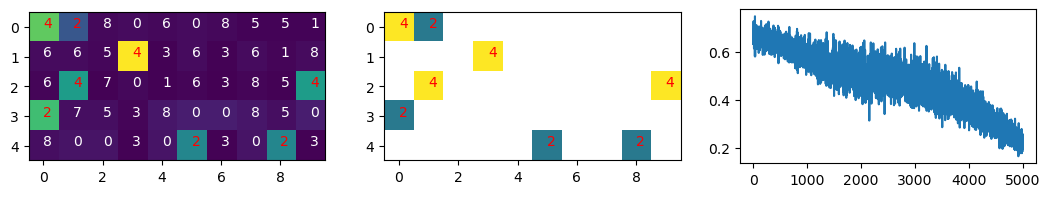

i=6000, loss=0.08949023485183716


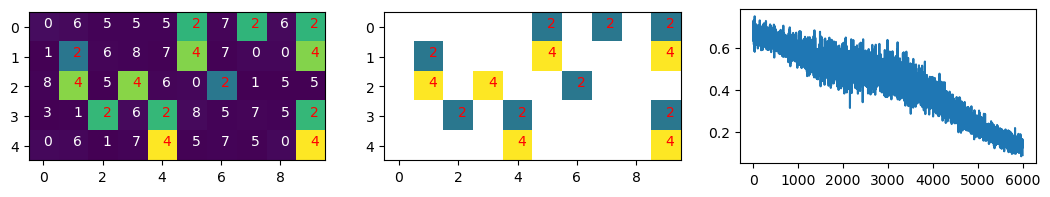

i=7000, loss=0.10063999891281128


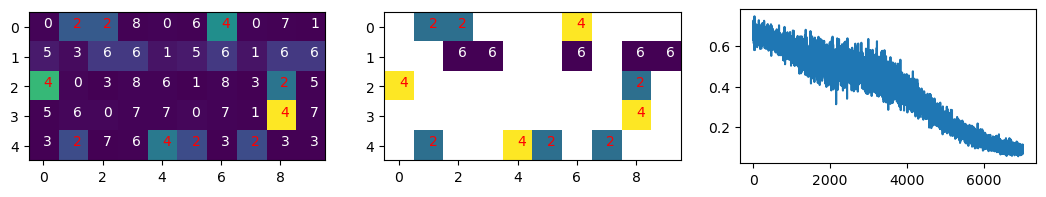

i=8000, loss=0.0674499049782753


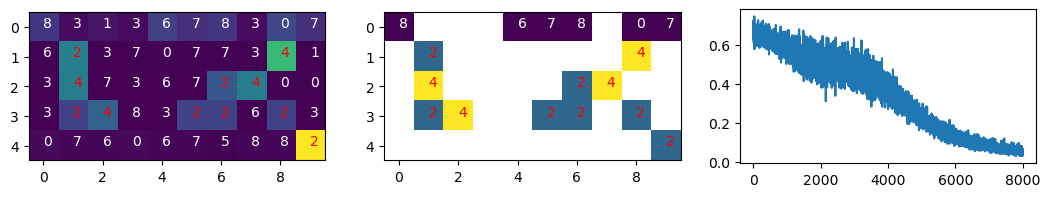

i=9000, loss=0.025479983538389206


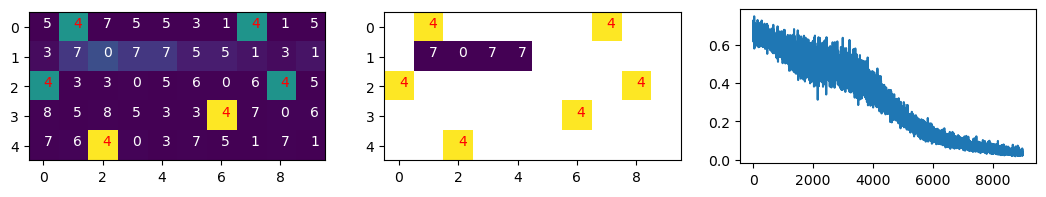

i=10000, loss=0.0156724713742733


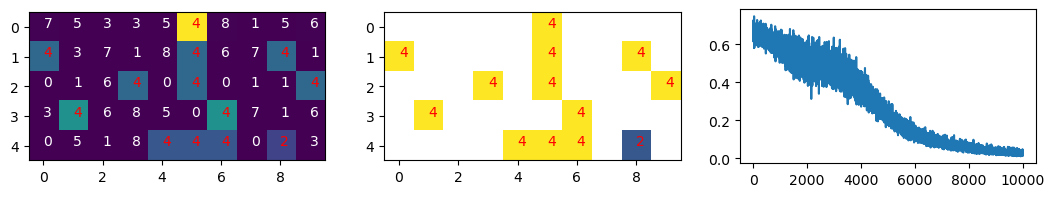

In [19]:
def train():
    model = AttentionModel()
    opt = torch.optim.Adam(model.parameters(),lr = 5e-5)
    s = 2
    traj = []
    for i in range(10001):
        x,y = make_batch(100)
        p = model.forward(x)
        loss = torch.nn.functional.binary_cross_entropy(p,y)
        loss.backward()
        traj.append(float(loss))
        if i % 1000 == 0:
            print(f"i={i}, loss={loss}")
            plot(model,5,traj)
            #plt.savefig('attention_{}.png'.format(str(i).zfill(6)))
            plt.show()
        opt.step()
        opt.zero_grad()
    return traj

training = train()